In [1]:
import os
from torchvision import datasets
import numpy as np
import cv2                
import matplotlib.pyplot as plt 
import torch
import torchvision.models as models
import torchvision
from PIL import Image
import torchvision.transforms as transforms


In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

print(use_cuda)

True


In [3]:
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

def show_dataset(dataset, n=15):
    img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))for i in range(len(dataset))))
    plt.imshow(img)
    plt.axis('off')

In [4]:
import PIL

In [5]:
train_dir = 'images/train'
test_dir = 'images/test'

In [6]:
from imgaug import augmenters as iaa
import imgaug as ia

### Augmentation

In [7]:
class ImgAugTransform1:
    
    def __init__(self):
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        self.aug = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Invert(0.05, per_channel=True)),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)



In [62]:

Xtransform=torchvision.transforms.Compose([
    ImgAugTransform1(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
  
    
])
train_data2=datasets.ImageFolder(train_dir , transform=Xtransform)


'\nXtransform=torchvision.transforms.Compose([\n    ImgAugTransform1(),\n    lambda x: PIL.Image.fromarray(x),\n    torchvision.transforms.Resize((224,224)),\n    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),\n    torchvision.transforms.RandomHorizontalFlip(),\n    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),\n  \n    \n])\ntrain_data2=datasets.ImageFolder(train_dir , transform=Xtransform)\n'

In [8]:
Ftransforms = torchvision.transforms.Compose([
    ImgAugTransform1(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    
])

C:\Users\anush\Anaconda3\envs\nano\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
C:\Users\anush\Anaconda3\envs\nano\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


In [9]:
train_data = datasets.ImageFolder(train_dir , transform=Ftransforms)
test_data= datasets.ImageFolder(test_dir, transform=Ftransforms)

C:\Users\anush\Anaconda3\envs\nano\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


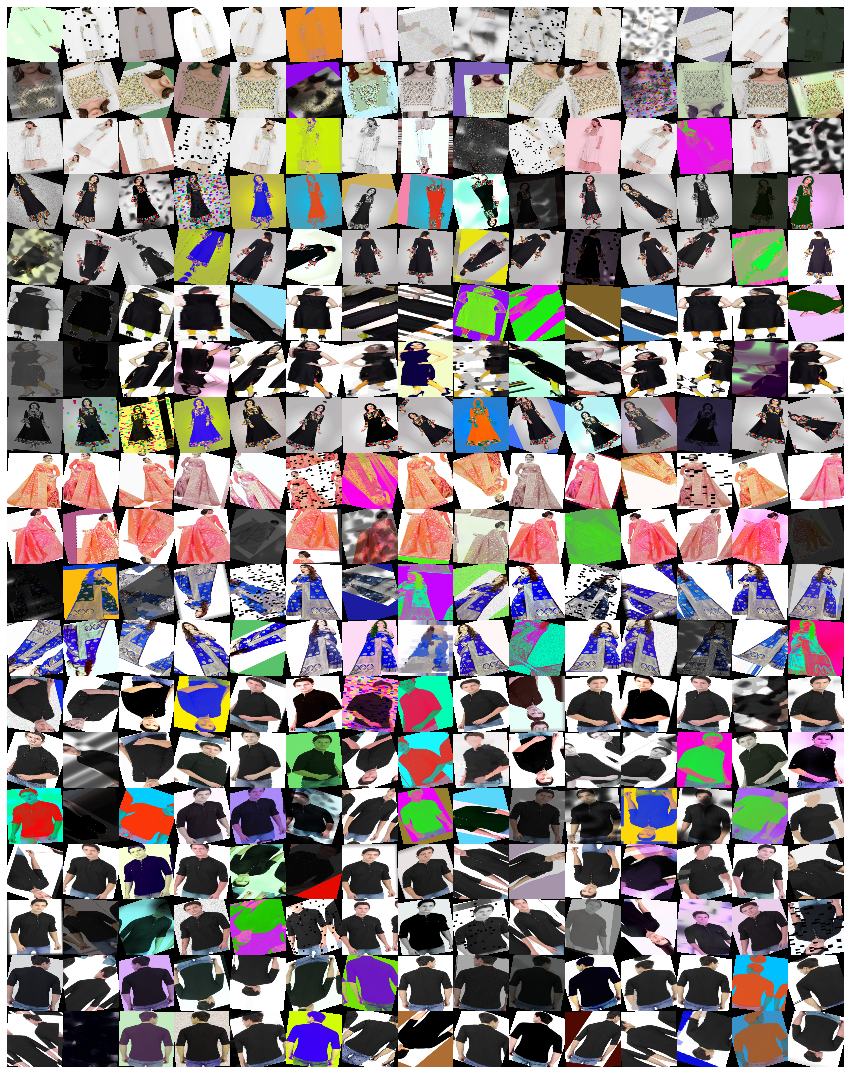

In [61]:
show_dataset(train_data2)

## Training

In [10]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=128)

In [11]:
print(train_data.classes)

['kurti', 'saree', 'shirt']


In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
loaders_transfer = {
    'train': trainloader,
   
    'test': testloader
}


In [14]:
# Load the pretrained model from pytorch
res50 = models.resnet50(pretrained=True)

In [15]:
print(res50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [16]:
import torchvision.models as models
import torch.nn as nn
model_transfer=res50

for name,child in model_transfer.named_children():
    if name in ['fc']:
        print(name + 'is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + 'is frozen')
        for param in child.parameters():
            param.requires_grad = False

model_transfer.fc = nn.Sequential(
               nn.Linear(2048, 516),
               nn.ReLU(inplace=True),
               nn.Linear(516,64),
               nn.ReLU(inplace=True),
               nn.Linear(64,3))


if use_cuda:
    model_transfer = model_transfer.cuda()

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is frozen
layer3is frozen
layer4is frozen
avgpoolis frozen
fcis unfrozen


In [17]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [18]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer =  optim.SGD(filter(lambda p:p.requires_grad,model_transfer.parameters()), lr=0.002, momentum=0.9)
## need to pass only those param that are unfrrozen!!

In [83]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    #valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        #valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            ## find the loss and update the model parameters accordingly
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
       

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
        
       
        
        #torch.save(model.state_dict(),save_path)
        state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict(), 'losslogger': criterion, }
        torch.save(state,save_path)
          
            
    # return trained model
    return model




In [84]:
# train the model
n_epochs=100
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')



Epoch: 1 	Training Loss: 1.090599
Epoch: 2 	Training Loss: 1.085830
Epoch: 3 	Training Loss: 1.090013
Epoch: 4 	Training Loss: 1.092178
Epoch: 5 	Training Loss: 1.082597
Epoch: 6 	Training Loss: 1.095163
Epoch: 7 	Training Loss: 1.082295
Epoch: 8 	Training Loss: 1.078190
Epoch: 9 	Training Loss: 1.073914
Epoch: 10 	Training Loss: 1.073534
Epoch: 11 	Training Loss: 1.062810
Epoch: 12 	Training Loss: 1.064210
Epoch: 13 	Training Loss: 1.066527
Epoch: 14 	Training Loss: 1.050139
Epoch: 15 	Training Loss: 1.055469
Epoch: 16 	Training Loss: 1.053100
Epoch: 17 	Training Loss: 1.042309
Epoch: 18 	Training Loss: 1.037457
Epoch: 19 	Training Loss: 1.045813
Epoch: 20 	Training Loss: 1.027060
Epoch: 21 	Training Loss: 1.024737
Epoch: 22 	Training Loss: 1.022358
Epoch: 23 	Training Loss: 1.010914
Epoch: 24 	Training Loss: 1.007515
Epoch: 25 	Training Loss: 1.013332
Epoch: 26 	Training Loss: 1.007248
Epoch: 27 	Training Loss: 1.007553
Epoch: 28 	Training Loss: 1.009977
Epoch: 29 	Training Loss: 0.9

In [83]:
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [19]:
checkpoint = torch.load('model_transfer.pt')
model_transfer.load_state_dict(checkpoint['state_dict'])
optimizer_transfer.load_state_dict(checkpoint['optimizer'])
n_epochs = checkpoint['epoch']
criterion_transfer = checkpoint['losslogger']

## Testing

In [86]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [87]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.518940


Test Accuracy: 100% ( 5/ 5)


## Final Pipeline

In [20]:
class_names= train_data.classes
print(len(class_names))
print(class_names[0])

3
kurti


In [25]:
def predict_product(img_path):
    # load the image and return the predicted breed
    transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
    file = img_path
    file = Image.open(file).convert('RGB')
    img = transform(file).unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model_transfer.eval()
    
    with torch.no_grad():
        
        out = model_transfer(img.to(device))
        ps = torch.exp(out)
        top_p, top_class = ps.topk(1, dim=1)
        index = top_class.item()
    return class_names[index]

In [26]:
import matplotlib.pyplot as plt
import matplotlib
def display_product(file):
    file = Image.open(file).convert('RGB')
    plt.figure(figsize = (40,5))
    plt.imshow(file)
    matplotlib.pyplot.text(5, -20, "HEllO, Lets detect the product !",
    color='black', fontsize=15)
    plt.show()

In [27]:
def run_app(img_path):

        product_name = predict_product(img_path)
        display_product(img_path)
        print("Predicted product is :", product_name)


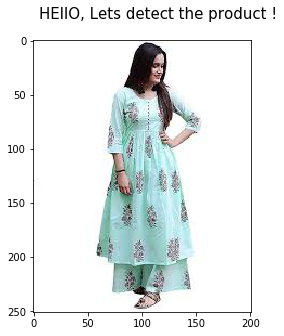

Predicted product is : kurti


In [28]:
run_app('images/apptest/test1.jpeg')

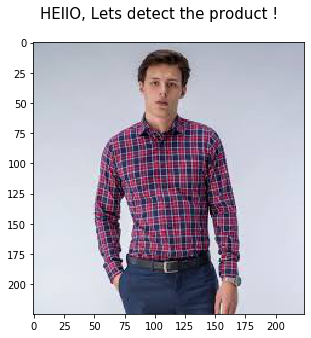

Predicted product is : shirt


In [29]:
run_app('images/apptest/test2.jpeg')

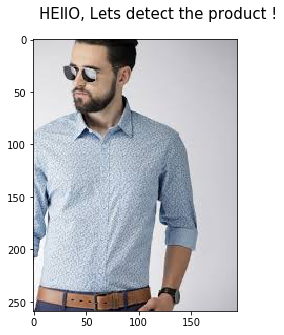

Predicted product is : shirt


In [30]:
run_app('images/apptest/test3.jpeg')

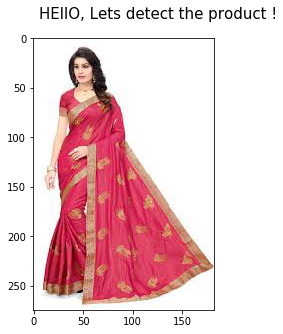

Predicted product is : saree


In [31]:
run_app('images/apptest/test4.jpeg')

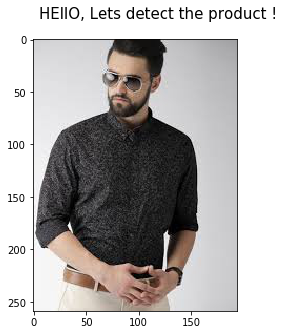

Predicted product is : shirt


In [32]:
run_app('images/apptest/test5.jpeg')

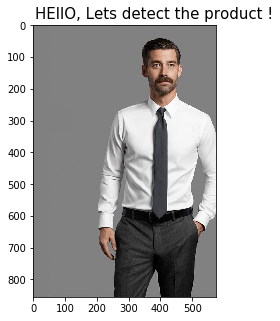

Predicted product is : shirt


In [33]:
run_app('images/apptest/test6.jpg')

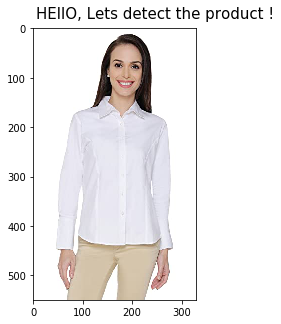

Predicted product is : kurti


In [34]:
run_app('images/apptest/test7.jpg')

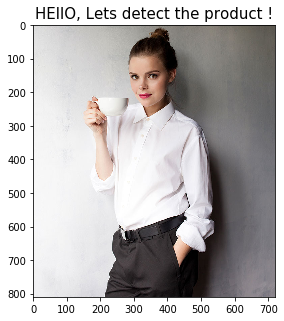

Predicted product is : shirt


In [35]:
run_app('images/apptest/test8.jpg')

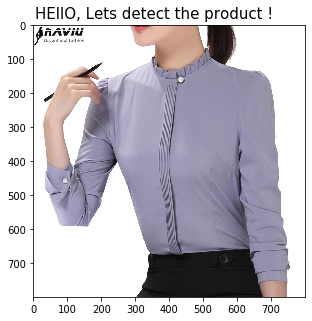

Predicted product is : shirt


In [36]:
run_app('images/apptest/test9.jpg')

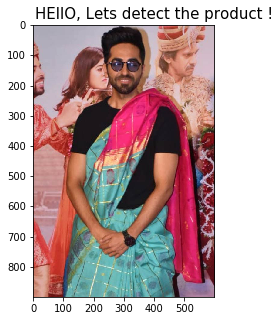

Predicted product is : shirt


In [37]:
run_app('images/apptest/test10.jpg')

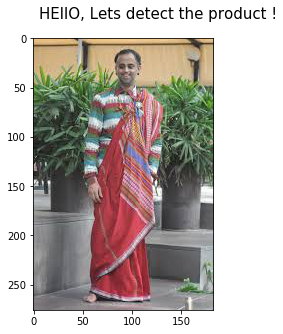

Predicted product is : saree


In [38]:
run_app('images/apptest/test11.jpeg')

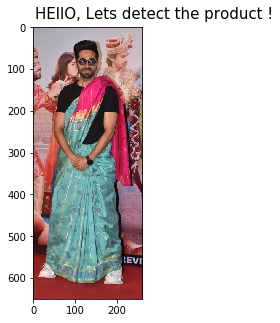

Predicted product is : saree


In [39]:
run_app('images/apptest/test12.jpg')

In [42]:
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils

In [64]:
def make_heatmap(image,true_image, true_class, k=8, stride=8): 
    """
    Input image is of size (1, c, w, h) typically (1, 3, 224, 224) for vgg16
    true_class is a number corresponding to imagenet classes
    k in the filter size (c, k, k)
    """
    heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), int(((image.shape[3]-k)/stride)+1))
    image = image.data

    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.ones(image.shape)
            h_filter[:,:,j:j+k, i:i+k] = 0
            temp_image = Variable((image.cuda() * h_filter.cuda()).cuda())
            temp_softmax = model_transfer(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            j += stride
            b += 1
        print(a)
        i += stride
        a += 1
    
    image = image.squeeze()
    
    true_image = image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    # Un-Normalize image
    #true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    
    # Plot both images
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (50, 50)
    
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 
    
    # Normalize heatmap
    heatmap = heatmap - heatmap.min()
#     heatmap = heatmap/heatmap.max()
    heatmap = np.uint8(255 * heatmap)
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off') 
    
    return heatmap

In [65]:
transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
file = 'images/apptest/test4.jpeg'
file1 = Image.open(file).convert('RGB')
myimg = transform(file1).unsqueeze(0)

In [66]:
#true_image=file

C:\Users\anush\Anaconda3\envs\nano\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


54


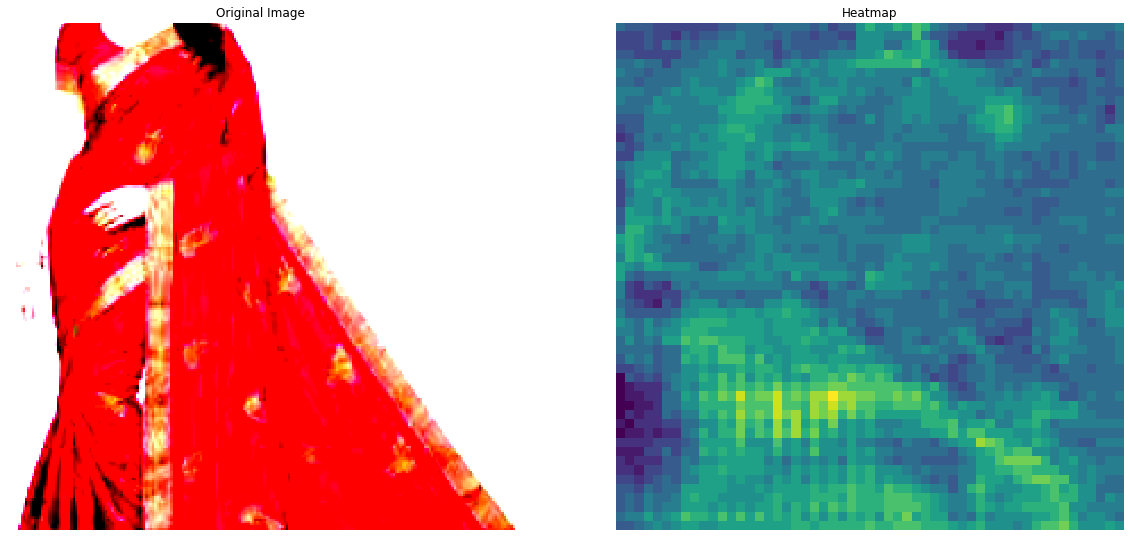

In [67]:
myheatmap = make_heatmap(myimg,file, 0, 8, 4)  # Extremely slow